In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.pipeline import Pipeline
from google.colab import files
import io

In [0]:
!pip install pybaseball

  Stored in directory: /root/.cache/pip/wheels/ec/07/ea/c76916b911a2f060d1dfa2e900460e6b5004ef334ff83cb419
Successfully built pybaseball


In [0]:
from pybaseball import statcast
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
import math

In [0]:
uploaded2 = files.upload()
df2 = pd.read_csv(io.StringIO(uploaded2['pitchmetadata.csv'].decode('utf-8')))

Saving pitchmetadata.csv to pitchmetadata.csv


In [0]:
df2.head(2)

,pitches,player_id,player_name,total_pitches,pitch_percent,ba,iso,babip,slg,woba,xwoba,xba,hits,abs,launch_speed,launch_angle,spin_rate,velocity,effective_speed,whiffs,swings,takes,eff_min_vel,release_extension,pos3_int_start_distance,pos4_int_start_distance,pos5_int_start_distance,pos6_int_start_distance,pos7_int_start_distance,pos8_int_start_distance,pos9_int_start_distance
0,3493,453286,Max Scherzer,3493,100.0,0.188,0.144,0.267,0.332,0.252,0.249,0.188,150,797,81.1,22.4,2302,89.4,88.76,604,1817,1652,-0.6,5.94,112,152,113,149,294,311,298
1,3427,434378,Justin Verlander,3427,100.0,0.200,0.160,0.274,0.360,0.260,0.241,0.190,156,781,82.1,24.8,2662,90.7,89.53,555,1745,1665,-1.2,5.79,110,153,116,152,288,315,291


In [0]:
id_list = df2['player_id']

In [0]:
# Scrapes all pitches for the list of player ids.
def getpitch(id):
  data = pd.DataFrame([])
  for pid in id:
    data = data.append(statcast_pitcher('2018-03-29', '2018-10-01', pid),ignore_index=True)
  return data

In [0]:
pitchdata = getpitch(id_list)

Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering 

In [0]:
pitchdata.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [0]:
pitchdata.pitch_type.value_counts()

FF    121847
SL     56100
FT     48154
CH     44596
CU     31398
SI     23654
FC     17973
KC     12362
FS      4698
EP       193
PO        40
SC        37
Name: pitch_type, dtype: int64

In [0]:
pitchdata.shape

(362351, 89)

In [0]:
def pitchclean(df):
  # load data
  pitch1 = df
  
  # definitions
  cols = ['player_name','game_date','pitch_type','stand','balls','strikes','on_3b','on_2b','on_1b','outs_when_up','inning','inning_topbot','at_bat_number',
       'pitch_number','bat_score','fld_score','if_fielding_alignment','of_fielding_alignment']
  pitch_dict = {'AB':1,'AS':2,'CH':3,'CU':4,'EP':5,'FC':6,'FF':7,'FO':8,'FS':9,'FT':10,
              'GY':11,'IN':12,'KC':13,'KN':14,'NP':15,'PO':16,'SC':17,'SI':18,
              'SL':19,'UN':20}
  nan_cols = ['on_3b','on_2b','on_1b']
  cat_cols = ['stand','inning_topbot','if_fielding_alignment','of_fielding_alignment']
  
  # data cleaning
  pitch2 = pitch1[cols]
  pitch2 = pitch2.dropna(subset = ['pitch_type']) # drops nan values of pitch type, there are only a few instances in the data
  pitches = pitch2.pitch_type.unique() # records what type of pitches pitcher throws
  pitch2['pitch_type'] = pitch2.pitch_type.replace(pitch_dict).astype('int64') # replace pitch strings with integers
  
  # convert raw game at bats into at bats within inning
  pitch2['ab_inn'] = pitch2.groupby(['player_name','game_date','inning'])['at_bat_number'].transform(lambda x: x - (x.min() - 1))
  
  # binarize men on base
  pitch2['on_3b'] = (pitch2['on_3b'].notnull()).astype('int')
  pitch2['on_2b'] = (pitch2['on_2b'].notnull()).astype('int')
  pitch2['on_1b'] = (pitch2['on_1b'].notnull()).astype('int')
  #get dummies for categorical columns
  pitch2 = pd.get_dummies(pitch2, columns=cat_cols)
  return pitch2

In [0]:
def pitchpred(df):
  nb = MultinomialNB(alpha=1.0)
  rf = RandomForestClassifier(n_estimators = 12)
  lr = LogisticRegression()
  
  pitkeys = df.groupby('player_name').groups.keys()
  
  rowslist = []
  y_scores = []
  y_target = []
  
  for i in pitkeys:
    newdf = df.loc[df['player_name']==str(i)]
  
    #values to help us gauge our model against. If you guess the pitcher's highest freq pitch 'maxpitch'
    #and divide by his total number of pitches 'totpitch', you have a baseline success rate to measure against
    maxpitch = max(newdf.pitch_type.value_counts())
    totpitch = newdf.pitch_type.count()
    guesspitch = maxpitch/totpitch
    
    if guesspitch == 1:
      continue

    no_of_pitches = len(newdf.pitch_type.unique())
    
    train_df, test_df= train_test_split(newdf, random_state=12)
    train_df_target = train_df['pitch_type']
    train_df = train_df.drop(['player_name','pitch_type'], axis=1)

    rf.fit(train_df.drop('game_date',axis=1),train_df_target)
    nb.fit(train_df.drop('game_date',axis=1),train_df_target)
    lr.fit(train_df.drop('game_date',axis=1),train_df_target)

    rfpred = accuracy_score(rf.predict(test_df.drop(['player_name','pitch_type','game_date'],axis=1)),test_df['pitch_type'])
    mnbpred = accuracy_score(nb.predict(test_df.drop(['player_name','pitch_type','game_date'],axis=1)),test_df['pitch_type'])
    lrpred = accuracy_score(lr.predict(test_df.drop(['player_name','pitch_type','game_date'],axis=1)),test_df['pitch_type'])

    dict1 = {'Name':i,'Guess_Toppitch': guesspitch,'Random_Forest':rfpred,'MultiNB':mnbpred,'Log_Reg':lrpred,'Unique Pitches':no_of_pitches}
    rowslist.append(dict1)
    
  findf = pd.DataFrame(rowslist)
  findf = findf[['Name','Unique Pitches','Guess_Toppitch','Log_Reg','Random_Forest','MultiNB']]
  return findf

In [0]:
cleandf = pitchclean(pitchdata)

In [0]:
reg_df = pitchpred(cleandf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

In [0]:
reg_df.head(10)

,Name,Unique Pitches,Guess_Toppitch,Log_Reg,Random_Forest,MultiNB
0,Aaron Nola,4,0.364570,0.344956,0.297634,0.373599
1,Aaron Sanchez,4,0.325153,0.405345,0.380846,0.394209
2,Alex Cobb,3,0.517029,0.578689,0.529508,0.522951
3,Alex Wood,3,0.429799,0.453355,0.360065,0.456628
4,Andrew Cashner,5,0.346808,0.356495,0.280967,0.344411
5,Andrew Heaney,3,0.581699,0.586357,0.509434,0.566038
6,Andrew Suarez,4,0.511469,0.479100,0.422830,0.448553
7,Anibal Sanchez,8,0.329572,0.342105,0.295113,0.342105
8,Anthony DeSclafani,6,0.349162,0.464286,0.404018,0.428571
9,Antonio Senzatela,4,0.640052,0.628272,0.560209,0.523560


In [0]:
df2 = df2[['player_name','ba','woba','xwoba']]

In [0]:
df2.head(3)

,player_name,ba,woba,xwoba
0,Max Scherzer,0.188,0.252,0.249
1,Justin Verlander,0.200,0.260,0.241
2,Dallas Keuchel,0.263,0.306,0.295


In [0]:
merged = pd.merge(reg_df,df2,left_on='Name',right_on='player_name').drop('player_name',axis=1)

In [0]:
merged.head(3)

,Name,Unique Pitches,Guess_Toppitch,Log_Reg,Random_Forest,MultiNB,ba,woba,xwoba
0,Aaron Nola,4,0.364570,0.344956,0.297634,0.373599,0.197,0.251,0.263
1,Aaron Sanchez,4,0.325153,0.405345,0.380846,0.394209,0.262,0.337,0.354
2,Alex Cobb,3,0.517029,0.578689,0.529508,0.522951,0.284,0.345,0.340


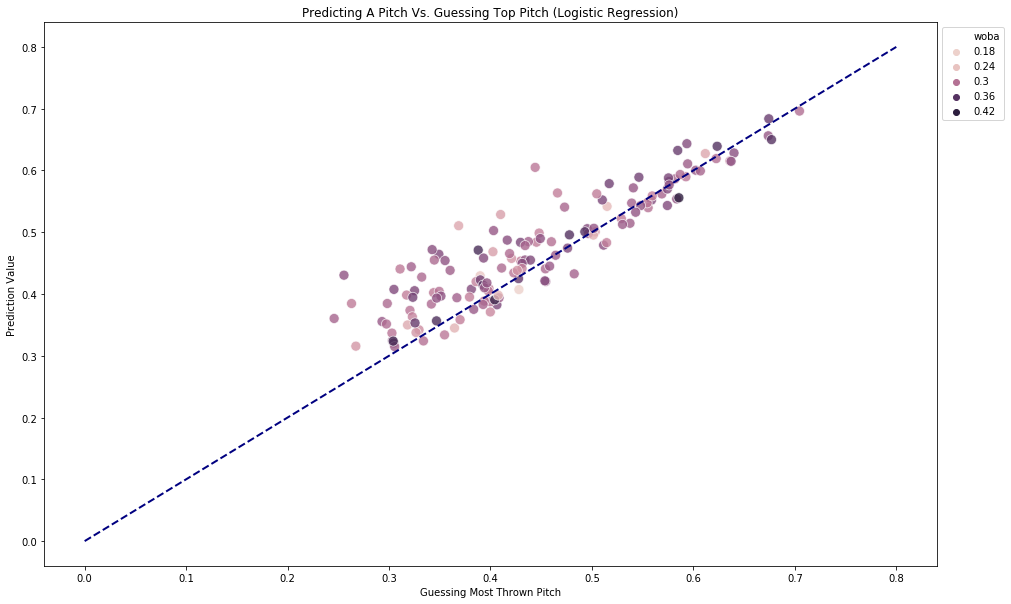

In [0]:
lw=2
plt.figure(figsize=[16,10])
plt.plot([0, 0.8], [0, 0.8], color='navy', lw=lw, linestyle='--')
ax = sns.scatterplot(data=merged, x='Guess_Toppitch',y='Log_Reg',hue='woba',s=100,alpha=0.8)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.ylabel('Prediction Value')
plt.xlabel('Guessing Most Thrown Pitch')
plt.title('Predicting A Pitch Vs. Guessing Top Pitch (Logistic Regression)')
plt.show()

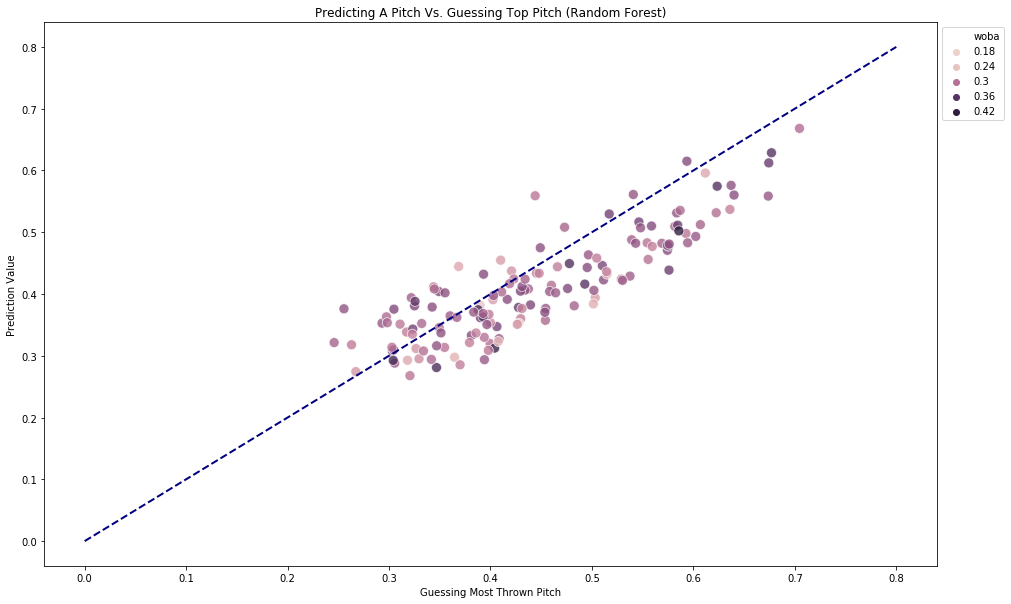

In [0]:
lw=2
plt.figure(figsize=[16,10])
plt.plot([0, 0.8], [0, 0.8], color='navy', lw=lw, linestyle='--')
ax = sns.scatterplot(data=merged, x='Guess_Toppitch',y='Random_Forest',hue='woba',s=100,alpha=0.8)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.ylabel('Prediction Value')
plt.xlabel('Guessing Most Thrown Pitch')
plt.title('Predicting A Pitch Vs. Guessing Top Pitch (Random Forest)')
plt.show()

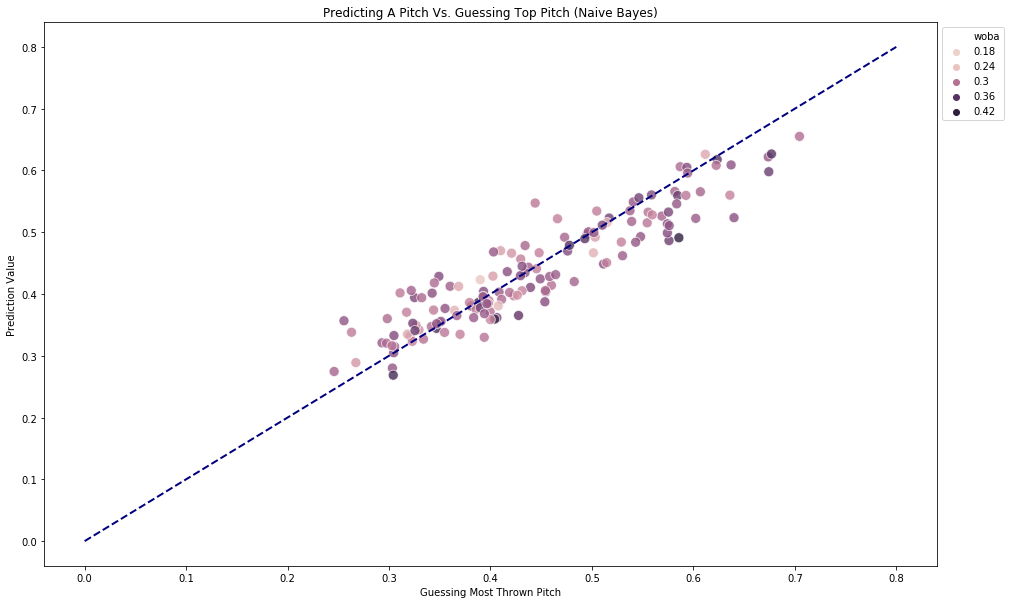

In [0]:
lw=2
plt.figure(figsize=[16,10])
plt.plot([0, 0.8], [0, 0.8], color='navy', lw=lw, linestyle='--')
ax = sns.scatterplot(data=merged, x='Guess_Toppitch',y='MultiNB',hue='woba',s=100,alpha=0.8)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.ylabel('Prediction Value')
plt.xlabel('Guessing Most Thrown Pitch')
plt.title('Predicting A Pitch Vs. Guessing Top Pitch (Naive Bayes)')
plt.show()

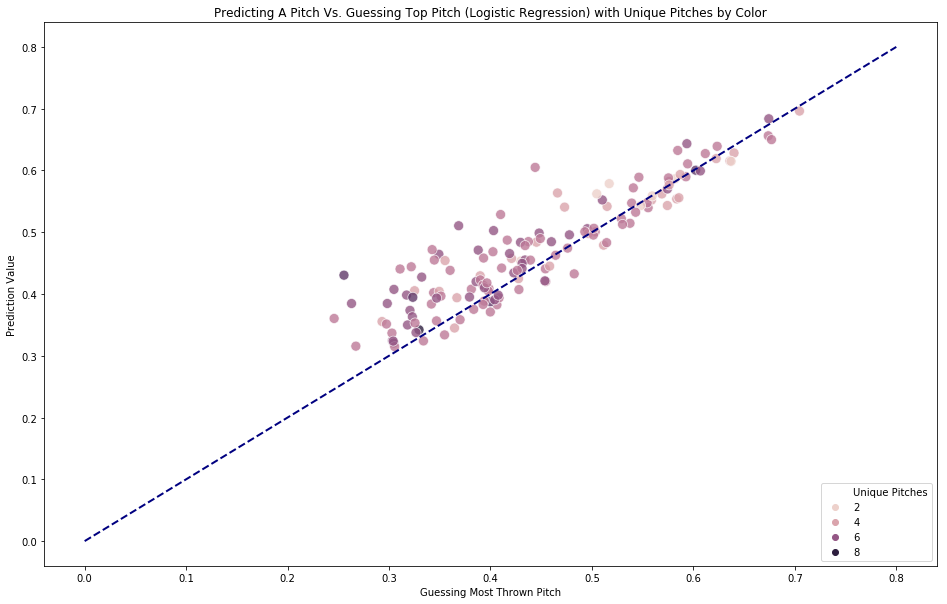

In [0]:
 lw=2
plt.figure(figsize=[16,10])
plt.plot([0, 0.8], [0, 0.8], color='navy', lw=lw, linestyle='--')
ax = sns.scatterplot(data=merged, x='Guess_Toppitch',y='Log_Reg',hue='Unique Pitches',s=100,alpha=0.8)
#for line in range(0,merged.shape[0]):
     #ax.text(merged.Guess_Toppitch[line]+0.005, merged.Log_Reg[line], merged.Name[line], horizontalalignment='left', size='medium', color='black')

plt.legend(loc='lower right')
plt.ylabel('Prediction Value')
plt.xlabel('Guessing Most Thrown Pitch')
plt.title('Predicting A Pitch Vs. Guessing Top Pitch (Logistic Regression) with Unique Pitches by Color')
plt.show()

In [0]:
def zoneclean(df):
  # load data
  pitch1 = df
  
  # definitions
  cols = ['player_name','game_date','pitch_type','stand','balls','strikes','on_3b','on_2b','on_1b','outs_when_up','inning','inning_topbot','at_bat_number',
       'pitch_number','bat_score','fld_score','if_fielding_alignment','of_fielding_alignment','zone']
  pitch_dict = {'AB':1,'AS':2,'CH':3,'CU':4,'EP':5,'FC':6,'FF':7,'FO':8,'FS':9,'FT':10,
              'GY':11,'IN':12,'KC':13,'KN':14,'NP':15,'PO':16,'SC':17,'SI':18,
              'SL':19,'UN':20}
  nan_cols = ['on_3b','on_2b','on_1b']
  cat_cols = ['stand','inning_topbot','if_fielding_alignment','of_fielding_alignment']
  
  # data cleaning
  pitch2 = pitch1[cols]
  pitch2 = pitch2.dropna(subset = ['pitch_type']) # drops nan values of pitch type, there are only a few instances in the data
  pitches = pitch2.pitch_type.unique() # records what type of pitches pitcher throws
  pitch2['pitch_type'] = pitch2.pitch_type.replace(pitch_dict).astype('int64') # replace pitch strings with integers
  pitch2 = pitch2.dropna(subset = ['zone'])
  pitch2.zone = pitch2.zone.astype(int)
  
  # convert raw game at bats into at bats within inning
  pitch2['ab_inn'] = pitch2.groupby(['player_name','game_date','inning'])['at_bat_number'].transform(lambda x: x - (x.min() - 1))
  
  # binarize men on base
  pitch2['on_3b'] = (pitch2['on_3b'].notnull()).astype('int')
  pitch2['on_2b'] = (pitch2['on_2b'].notnull()).astype('int')
  pitch2['on_1b'] = (pitch2['on_1b'].notnull()).astype('int')
  #get dummies for categorical columns
  pitch2 = pd.get_dummies(pitch2, columns=cat_cols)
  return pitch2

In [0]:
def zonepred(df):
  nb = MultinomialNB(alpha=1.0)
  rf = RandomForestClassifier(n_estimators = 5)
  lr = LogisticRegression()
  
  pitkeys = df.groupby('player_name').groups.keys()
  
  rowslist = []
  y_scores = []
  y_target = []
  
  for i in pitkeys:
    newdf = df.loc[df['player_name']==str(i)]
  
    #values to help us gauge our model against. If you guess the pitcher's highest freq pitch 'maxpitch'
    #and divide by his total number of pitches 'totpitch', you have a baseline success rate to measure against
    maxpitch = max(newdf.pitch_type.value_counts())
    totpitch = newdf.pitch_type.count()
    guesspitch = maxpitch/totpitch
    
    if guesspitch == 1:
      continue

    no_of_pitches = len(newdf.pitch_type.unique())
    
    train_df, test_df= train_test_split(newdf, random_state=110)
    train_df_target = train_df['zone']
    train_df = train_df.drop(['player_name','pitch_type','zone'], axis=1)

    rf.fit(train_df.drop('game_date',axis=1),train_df_target)
    nb.fit(train_df.drop('game_date',axis=1),train_df_target)
    lr.fit(train_df.drop('game_date',axis=1),train_df_target)

    rfpred = accuracy_score(rf.predict(test_df.drop(['player_name','pitch_type','game_date','zone'],axis=1)),test_df['zone'])
    mnbpred = accuracy_score(nb.predict(test_df.drop(['player_name','pitch_type','game_date','zone'],axis=1)),test_df['zone'])
    lrpred = accuracy_score(lr.predict(test_df.drop(['player_name','pitch_type','game_date','zone'],axis=1)),test_df['zone'])

    dict1 = {'Name':i,'Log_Reg':lrpred,'Random_Forest':rfpred,'MultiNB':mnbpred}
    rowslist.append(dict1)
    
  findf = pd.DataFrame(rowslist)
  findf = findf[['Name','Log_Reg','Random_Forest','MultiNB']]
  return findf

In [0]:
zone_clean = zoneclean(pitchdata)

In [0]:
zone_pred = zonepred(zone_clean)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

In [0]:
# This was trying to predict the zone a pitch gets thrown in rather than the pitch type.
# There are 9 zones in the strike zone and 4 zones outside the strike zone.
zone_pred

,Name,Log_Reg,Random_Forest,MultiNB
0,Aaron Nola,0.184309,0.117061,0.171856
1,Aaron Sanchez,0.202673,0.131403,0.211581
2,Alex Cobb,0.201639,0.126230,0.180328
3,Alex Wood,0.255319,0.148936,0.196399
4,Andrew Cashner,0.214502,0.119335,0.194864
5,Andrew Heaney,0.253991,0.134978,0.217707
6,Andrew Suarez,0.167472,0.119163,0.146538
7,Anibal Sanchez,0.312030,0.146617,0.278195
8,Anthony DeSclafani,0.229911,0.138393,0.185268
9,Antonio Senzatela,0.282723,0.180628,0.217277


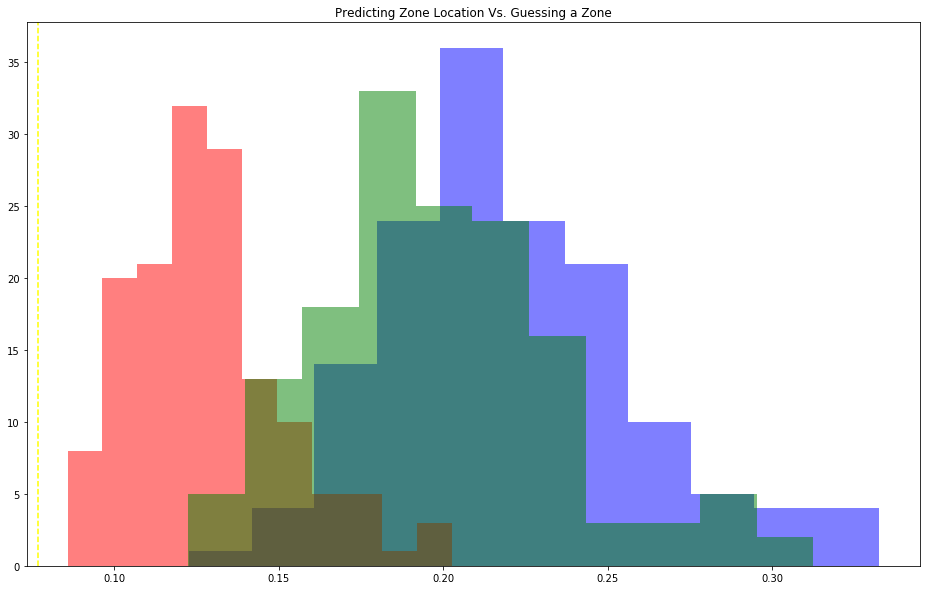

In [0]:
lw=2

plt.figure(figsize=[16,10])
ax = plt.hist(zone_pred.Log_Reg, alpha=.5, color='blue',bins='rice')
ax = plt.hist(zone_pred.Random_Forest, alpha=.5, color='red',bins='rice')
ax = plt.hist(zone_pred.MultiNB, alpha=.5, color='green',bins='rice')
plt.axvline(x=(1/13), linestyle='--', color = 'yellow')
#plt.legend(loc='upper left', bbox_to_anchor=(1,1))
#plt.ylabel('Prediction Value')
#plt.xlabel('Guessing Most Thrown Pitch')
plt.title('Predicting Zone Location Vs. Guessing a Zone')
plt.show()